In [39]:
import pyrealsense2 as rs
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d
from datetime import date

#Camera Setup
# Create a context object. This object owns the handles to all connected realsense devices
pipe = rs.pipeline()
# Configure streams
config = rs.config()
config.enable_stream(rs.stream.depth, 640, 480, rs.format.z16, 30)
config.enable_stream(rs.stream.color)
# Start streaming
pipe.start(config)
#Image Capture
for x in range(5):
    pipe.wait_for_frames()
frameset=pipe.wait_for_frames()
color_frame = frameset.get_color_frame()
depth_frame = frameset.get_depth_frame()

print("Frames Captured")
color = np.asanyarray(color_frame.get_data())
colorizer = rs.colorizer()
# Create alignment primitive with color as its target stream:
align = rs.align(rs.stream.color)
frameset = align.process(frameset)

#Getting ply file
ply = rs.save_to_ply("test.ply")
ply.set_option(rs.save_to_ply.option_ply_binary, False) #?
ply.set_option(rs.save_to_ply.option_ply_normals, True) #?
ply.process(colorizer.process(frameset))

pipe.stop()



Frames Captured


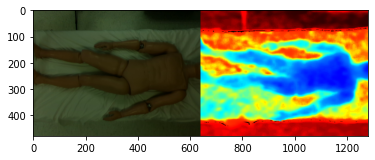

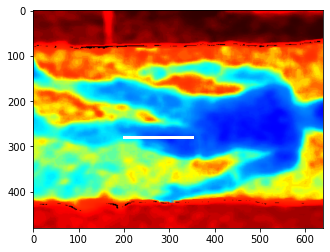

In [40]:
# Update color and depth frames:
aligned_depth_frame = frameset.get_depth_frame()
colorized_depth = np.asanyarray(colorizer.colorize(aligned_depth_frame).get_data())

# Show the two frames together:
images = np.hstack((color, colorized_depth))
plt.imshow(images)
plt.show()
x = [200, 350]
y = [280, 280]
plt.plot(x, y, color="white", linewidth=3)
plt.imshow(colorized_depth)
plt.show()

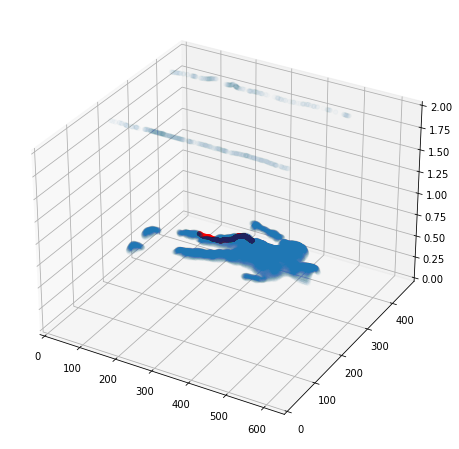

In [41]:
points=[[],[],[]]
selected_points=[[],[],[]]
body_points=[[],[],[]]

for x in range(600):
    for y in range(120,380):
        if (not (y==180)) or (x<200 or x>350):
            points[0].append(x)
            points[1].append(y)
            points[2].append(2.1-depth_frame.get_distance(x,y))
        else:
            selected_points[0].append(x)
            selected_points[1].append(280)
            selected_points[2].append(2.1-depth_frame.get_distance(x,280))

for x in range(70,550):
    for y in range(120,380):
        if depth_frame.get_distance(x,y)<=1.50:
            body_points[0].append(x)
            body_points[1].append(y)
            body_points[2].append(2.1-depth_frame.get_distance(x,y))

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(selected_points[0], selected_points[1], selected_points[2],c='r')
"""ax.scatter(points[0], points[1], points[2],alpha=.01) """
ax.scatter(body_points[0], body_points[1], body_points[2],alpha=.01)
ax.set_xlim3d(0,640)
ax.set_ylim3d(0,480)
ax.set_zlim3d(0,2)
plt.show()

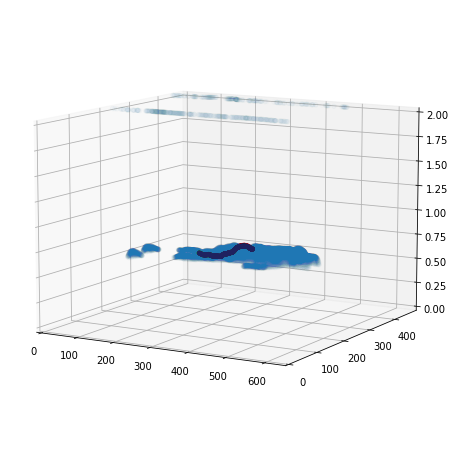

In [42]:
points=[[],[],[]]
selected_points=[[],[],[]]
body_points=[[],[],[]]

for x in range(600):
    for y in range(120,380):
        if (not (y==180)) or (x<200 or x>350):
            points[0].append(x)
            points[1].append(y)
            points[2].append(2.1-depth_frame.get_distance(x,y))
        else:
            selected_points[0].append(x)
            selected_points[1].append(280)
            selected_points[2].append(2.1-depth_frame.get_distance(x,280))

for x in range(70,550):
    for y in range(120,380):
        if depth_frame.get_distance(x,y)<=1.50:
            body_points[0].append(x)
            body_points[1].append(y)
            body_points[2].append(2.1-depth_frame.get_distance(x,y))

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(selected_points[0], selected_points[1], selected_points[2],c='r')
"""ax.scatter(points[0], points[1], points[2],alpha=.01) """
ax.scatter(body_points[0], body_points[1], body_points[2],alpha=.01)
ax.set_xlim3d(0,640)
ax.set_ylim3d(0,480)
ax.set_zlim3d(0,2)
ax.elev=10
plt.show()

[Open3D INFO] Picked point #1655 (-0.23, -0.043, -1.5) to add in queue.
[Open3D INFO] Picked point #5458 (0.0067, -0.083, -1.4) to add in queue.


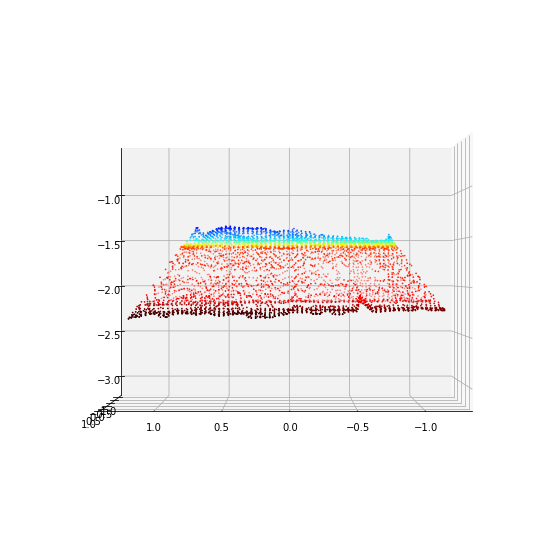

In [112]:
#Normals Vis
import open3d as o3d
from pyntcloud import PyntCloud

pcd = o3d.io.read_point_cloud("/home/sashawald/Documents/shaving_main/depth_results/test.ply")

#Visualize Original
#print(pcd)
#o3d.visualization.draw_geometries([pcd])

pcd = pcd.voxel_down_sample(voxel_size=0.035)
#use draw_geometries if you don't need to edit the result
o3d.visualization.draw_geometries_with_editing([pcd])
cloud = PyntCloud.from_instance("open3d", pcd)
scene = cloud.plot(return_scene=True, position=(1,1,1))


In [115]:
#Code  for picking specific points: shift+left click to select, shift+right click to deselect
#close visualization window to return selected points
import numpy as np
from LineMesh import *

vis = o3d.visualization.VisualizerWithEditing()
vis.create_window()
vis.add_geometry(pcd)
vis.run()  
vis.destroy_window()
pdata = vis.get_picked_points()


[Open3D INFO] Picked point #4944 (-0.3, -0.073, -1.5) to add in queue.
[Open3D INFO] No point has been picked.
[Open3D INFO] Picked point #2275 (0.045, -0.14, -1.4) to add in queue.


In [116]:
#Visualize Cylinder Mesh + Point Cloud
points = [pcd.points[(pdata[0])],
          pcd.points[(pdata[1])]]
lines = [[0,1]]
colors = [[1, 0, 0] for i in range(len(lines))]
line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(points),
    lines=o3d.utility.Vector2iVector(lines),
)
line_set.colors = o3d.utility.Vector3dVector(colors)

#using LineMesh module to get a corresponding cylinder
line_mesh=LineMesh(points,radius=0.01)
line_mesh_geoms=line_mesh.cylinder_segments


o3d.visualization.draw_geometries([pcd]+line_mesh_geoms)

In [124]:
#Ray Casting
#Without some downsampling, this process will take 10-15 seconds
cyl = o3d.t.geometry.TriangleMesh.from_legacy(line_mesh_geoms[0])
scene = o3d.t.geometry.RaycastingScene()
cyl_id = scene.add_triangles(cyl)
print(cyl_id)

pclrays = np.ndarray.tolist(np.asarray(pcd.points))
for ray in pclrays:
    ray.extend([0,0,1])

rays = o3d.core.Tensor(pclrays,
                       dtype=o3d.core.Dtype.Float32)
ans = (scene.cast_rays(rays))['geometry_ids']
count=0
found=[]
for val in ans:
    if val == 0:
        found.append(count)
    count=count+1

foundpcl = pcd.select_by_index(found)
foundpcl.paint_uniform_color([1, 0, 0])
#foundpcl = foundpcl.voxel_down_sample(voxel_size=0.025)
o3d.visualization.draw_geometries([pcd,foundpcl])

0
[1400, 2208, 2275, 3273, 3565, 4741, 4790, 4944, 5496, 5503]


In [123]:
pcd.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1,
                                                          max_nn=30))
print(np.asarray(pcd.normals))

[[-0.0183573   0.09381943  0.99541997]
 [ 0.02964491 -0.08973612  0.99552429]
 [ 0.04652497 -0.17680697  0.98314532]
 ...
 [-0.13946951 -0.18699925  0.97240914]
 [-0.21651982  0.54441517  0.81038959]
 [-0.15929274 -0.14523409  0.97649008]]
